#### Training with MNIST for all classes

In [1]:
import idx2numpy
X_train_3D = idx2numpy.convert_from_file('MNIST_dataset/train-images-idx3-ubyte')
X_train = X_train_3D.flatten().reshape(60000,784)

y_train = idx2numpy.convert_from_file('MNIST_dataset/train-labels-idx1-ubyte')
print(X_train.shape, y_train.shape)

X_test_3D = idx2numpy.convert_from_file('MNIST_dataset/t10k-images-idx3-ubyte')
X_test =  X_test_3D.flatten().reshape(10000,784)

y_test = idx2numpy.convert_from_file('MNIST_dataset/t10k-labels-idx1-ubyte')
print(X_test.shape, y_test.shape)

import numpy as np
from sklearn.utils import shuffle
X_shuffle,y_shuffle = shuffle(X_train,y_train)
X_train = X_shuffle[0:50000]
y_train = y_shuffle[0:50000]

from sklearn import tree
from sklearn.model_selection import cross_val_predict

#dt_clf = tree.DecisionTreeClassifier(max_depth=20, max_leaf_nodes=300)
#dt_clf = tree.DecisionTreeClassifier(max_depth=4, max_leaf_nodes=20)
dt_clf = tree.DecisionTreeClassifier(max_depth=8)

#y_train_pred = cross_val_predict(dt_clf, X_train, y_train, cv=2)
print(dt_clf.fit(X_train, y_train))

print('Number of nodes in the decision tree {}.'.format(dt_clf.tree_.node_count))
print('Number of threshold in the decision tree {}.'.format(len(dt_clf.tree_.threshold)))
print('Number of leaves in the decision tree {}.'.format(dt_clf.tree_.n_leaves))

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, dt_clf.predict(X_test)), accuracy_score(y_train, dt_clf.predict(X_train)))

(60000, 784) (60000,)
(10000, 784) (10000,)
DecisionTreeClassifier(max_depth=8)
Number of nodes in the decision tree 505.
Number of threshold in the decision tree 505.
Number of leaves in the decision tree 253.
0.8205 0.83232


In [2]:
threshold = dt_clf.tree_.threshold
import pandas as pd
df_train = pd.DataFrame(data = X_train, columns = range(X_train[0].shape[0]))
df_test = pd.DataFrame(data = X_test, columns = range(X_test[0].shape[0]))
df_train.shape, df_test.shape
df = pd.concat([df_train, df_test])
unique_vals = []
for i in df.columns:
    unique_vals.append(df[i].unique())
flatten_list = np.concatenate(unique_vals).ravel()
print('Max and Min values of thresholds in decision tree are', max([int(i) for i in list(set(threshold))]), min([int(i) for i in list(set(threshold))]))

Max and Min values of thresholds in decision tree are 253 -2


#### Displaying the nodes/leaves that were visited for training each class. Also display which are the intermeduate nodes and which are the leaves.

In [28]:
# Get the paths to the leaf nodes for each class
clf = dt_clf
leaf_paths = {}
for class_label in np.unique(y_train):
    leaf_paths[class_label] = clf.decision_path(X_train[y_train == class_label])

# Group the leaf nodes for each class
class_groups = {}
for class_label, paths in leaf_paths.items():
    group = {'leaves': set(), 'intermediate': set()}
    for path in paths:
        # Get the indices of the nodes in the path
        node_indices = np.where(path.toarray().flatten())[0]
        # Identify leaf nodes and intermediate nodes
        for idx in node_indices:
            node = clf.tree_.value[idx].argmax()
            if clf.tree_.children_left[idx] == -1 and clf.tree_.children_right[idx] == -1:
                # Verify leaf node belongs to the current class
                if node == class_label:
                    group['leaves'].add(idx)
            else:
                group['intermediate'].add(idx)
    class_groups[class_label] = group

# Verify leaf nodes don't belong to other classes
for class_label, groups in class_groups.items():
    for other_class_label, other_groups in class_groups.items():
        if other_class_label != class_label:
            intersection = groups['leaves'].intersection(other_groups['leaves'])
            if intersection:
                print(f"Warning: Leaf nodes for class {class_label} intersect with class {other_class_label}: {intersection}")

leaf_nodes_per_class = {}
intermediate_nodes_per_class = {}
# Print the groups
for class_label, groups in class_groups.items():
    print(f"Class {class_label}:")
    print("Intermediate Nodes:", groups['intermediate'])
    intermediate_nodes_per_class[class_label] = groups['intermediate']
    print("Leaf Nodes:", groups['leaves'])
    leaf_nodes_per_class[class_label] = groups['leaves']

Class 0:
Intermediate Nodes: {0, 1, 2, 3, 4, 5, 6, 7, 20, 21, 22, 25, 28, 29, 35, 36, 37, 41, 44, 45, 48, 51, 52, 53, 57, 58, 61, 64, 65, 66, 67, 68, 71, 74, 75, 81, 82, 83, 86, 89, 90, 93, 96, 97, 98, 99, 102, 105, 106, 109, 112, 113, 117, 120, 121, 124, 127, 128, 129, 130, 131, 132, 135, 138, 139, 142, 145, 146, 147, 150, 153, 154, 157, 160, 161, 169, 170, 173, 176, 177, 181, 184, 185, 188, 191, 192, 193, 194, 195, 201, 205, 208, 209, 210, 213, 216, 217, 220, 223, 224, 225, 226, 229, 232, 233, 236, 239, 240, 241, 244, 247, 248, 251, 254, 255, 256, 257, 258, 259, 263, 266, 267, 270, 273, 274, 275, 278, 281, 285, 288, 289, 290, 291, 297, 301, 304, 305, 306, 309, 312, 313, 316, 319, 320, 321, 322, 323, 326, 336, 344, 345, 348, 351, 352, 353, 354, 357, 360, 361, 364, 367, 368, 369, 372, 375, 379, 382, 383, 384, 385, 386, 387, 390, 400, 408, 412, 415, 416, 417, 418, 421, 424, 425, 428, 431, 437, 439, 442, 443, 444, 445, 446, 452, 456, 459, 467, 471, 474, 475, 483, 487, 490, 491, 492, 498,

##### Sanity checks that there is no sharing of leaves between classes.

In [29]:
for i in intermediate_nodes_per_class.keys():
    for j in leaf_nodes_per_class.keys():
        if i!=j:
            intersection = leaf_nodes_per_class[i].intersection(leaf_nodes_per_class[j])
            if intersection:
                print(f'Warning: The leaf nodes between class {i} and {j} has common leaves: {intersection}.')
    

# Extracting the decision rules with different mechanism: `chain` of `if` statements

In [4]:
%%capture cap --no-stderr

from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += ":\n"
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"    label_class= {class_names[l]} #(proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += ['  ' + rule]
        
    return rules

cols = range(784)
features = [f'feature_num[{i}]' for i in cols]
class_names = [str(i) for i in dt_clf.classes_]
tree_ = dt_clf.tree_
feature_name = [
    features[i] if i != _tree.TREE_UNDEFINED else "undefined!"
    for i in tree_.feature
]
print ("def decision_tree_inference({}):".format('feature_num'))
print('  label_class= None')
            
rules = get_rules(dt_clf, features, class_names)
for r in rules:
    print(r)
print('  return label_class')
    
with open('mnist_decision_tree_inference.py', 'w') as f:
    f.write(cap.stdout)

In [5]:
from mnist_decision_tree_inference import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))

for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 0
    
y_train_pred_tree = []
for i,test_samples in enumerate(X_train):
    y_train_pred_tree.append(decision_tree_inference(test_samples))
    
for i in range(len(y_train_pred_tree)):
    if y_train_pred_tree[i] is None:
        y_train_pred_tree[i] = 0

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_test_pred_tree), accuracy_score(y_train, y_train_pred_tree))

0.8227 0.83562


#### Verifying that the number of 'if' statements is equal to the number of leaves.

In [6]:
with open('mnist_decision_tree_inference.py', 'r') as f:
    rules = f.readlines()

counter_if = 0
for rule in rules:
    if 'if' in rule:
        counter_if = counter_if+1
print(counter_if)

251


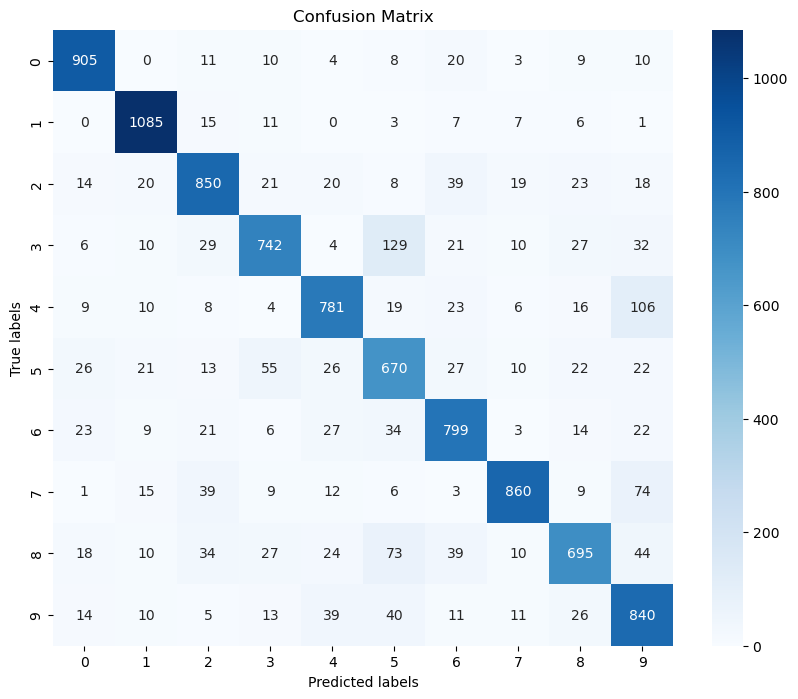

Precision: 0.8260025762534436
Recall: 0.8227
F1 Score: 0.8227837672516107
True Positives for Each Class: [ 905 1085  850  742  781  670  799  860  695  840]
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       980
           1       0.91      0.96      0.93      1135
           2       0.83      0.82      0.83      1032
           3       0.83      0.73      0.78      1010
           4       0.83      0.80      0.81       982
           5       0.68      0.75      0.71       892
           6       0.81      0.83      0.82       958
           7       0.92      0.84      0.87      1028
           8       0.82      0.71      0.76       974
           9       0.72      0.83      0.77      1009

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred_tree)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)

##### Forgetting class 9.   

0.7397


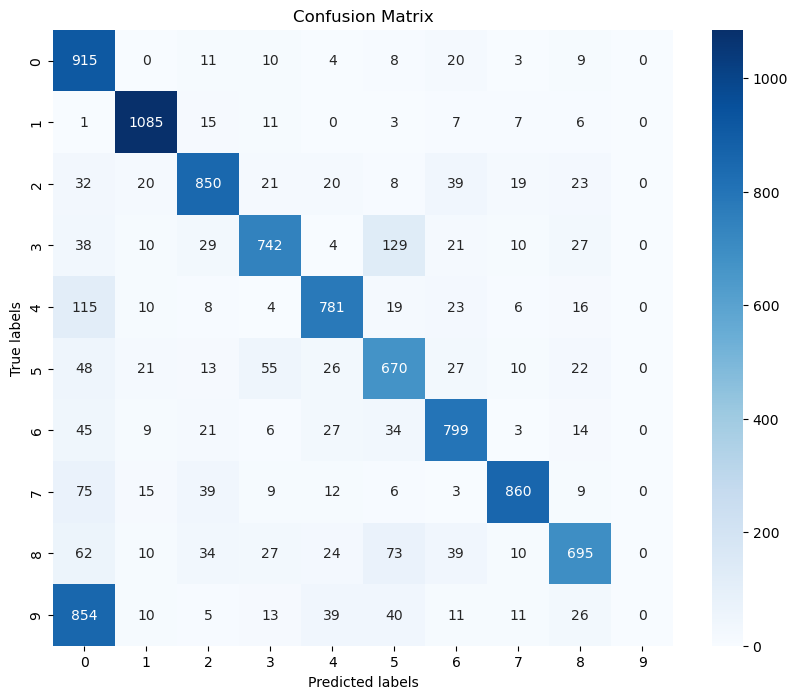

Precision: 0.7072451767566841
Recall: 0.7397
F1 Score: 0.7127503377877452
True Positives for Each Class: [ 915 1085  850  742  781  670  799  860  695    0]
              precision    recall  f1-score   support

           0       0.42      0.93      0.58       980
           1       0.91      0.96      0.93      1135
           2       0.83      0.82      0.83      1032
           3       0.83      0.73      0.78      1010
           4       0.83      0.80      0.81       982
           5       0.68      0.75      0.71       892
           6       0.81      0.83      0.82       958
           7       0.92      0.84      0.87      1028
           8       0.82      0.71      0.76       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.74     10000
   macro avg       0.70      0.74      0.71     10000
weighted avg       0.71      0.74      0.71     10000



C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_clas

In [8]:
forget_class = 9
with open('mnist_decision_tree_inference.py','r') as f:
    tree_ifel_code = f.readlines()
    f.close()
    
for idx,line in enumerate(tree_ifel_code):
    if f'label_class= {forget_class}' in line:
        tree_ifel_code[idx] = ''
        tree_ifel_code[idx-1] = ''
        

with open('forget_9_mnistdt.py', 'w') as f:
    f.writelines(tree_ifel_code)
    f.close()


from forget_9_mnistdt import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))


import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 0
        
print(accuracy_score(y_test, y_test_pred_tree))

cm = confusion_matrix(y_test, y_test_pred_tree)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)

#### Forgetting class 8

0.6694


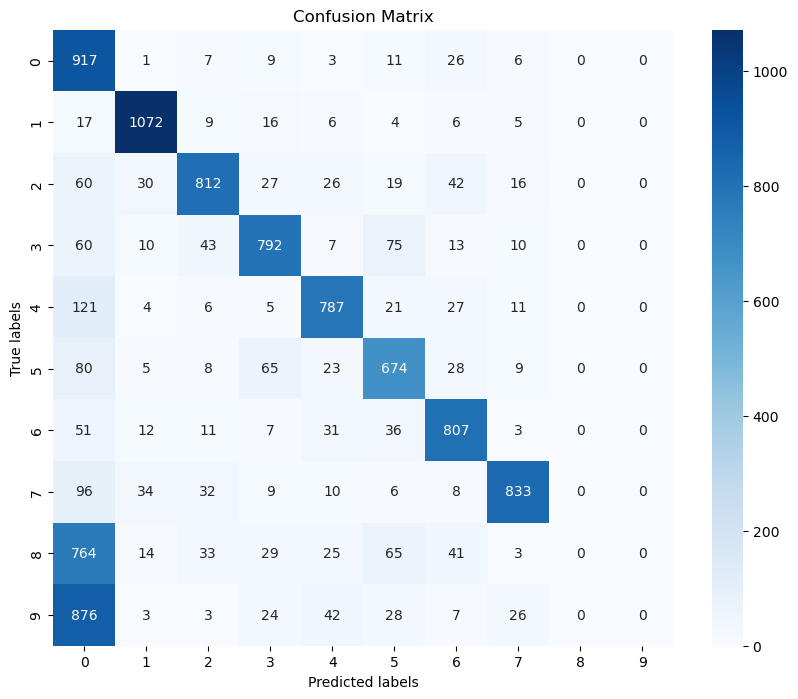

Precision: 0.6148544368928962
Recall: 0.6694
F1 Score: 0.6256735326674109
True Positives for Each Class: [ 917 1072  812  792  787  674  807  833    0    0]
              precision    recall  f1-score   support

           0       0.30      0.94      0.46       980
           1       0.90      0.94      0.92      1135
           2       0.84      0.79      0.81      1032
           3       0.81      0.78      0.79      1010
           4       0.82      0.80      0.81       982
           5       0.72      0.76      0.74       892
           6       0.80      0.84      0.82       958
           7       0.90      0.81      0.85      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.67     10000
   macro avg       0.61      0.67      0.62     10000
weighted avg       0.61      0.67      0.63     10000



C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_clas

In [8]:
forget_class = 8
with open('forget_9_mnistdt.py','r') as f:
    tree_ifel_code = f.readlines()
    f.close()
    
for idx,line in enumerate(tree_ifel_code):
    if f'label_class= {forget_class}' in line:
        tree_ifel_code[idx] = ''
        tree_ifel_code[idx-1] = ''
        

with open(f'forget_{forget_class}_mnistdt.py', 'w') as f:
    f.writelines(tree_ifel_code)
    f.close()


from forget_8_mnistdt import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))


import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 0
        
print(accuracy_score(y_test, y_test_pred_tree))

cm = confusion_matrix(y_test, y_test_pred_tree)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)

#### Forgetting class 7

0.5867


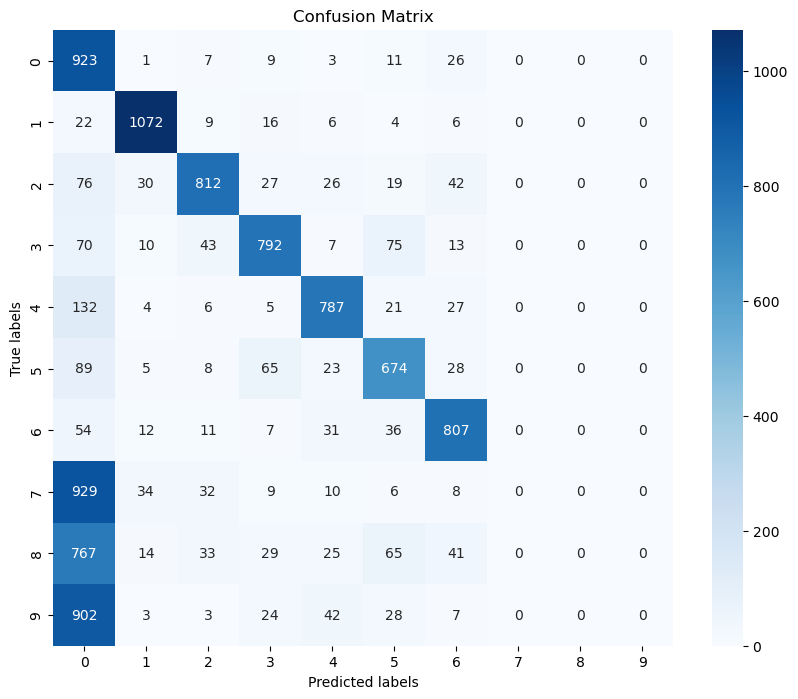

Precision: 0.5152547682840587
Recall: 0.5867
F1 Score: 0.5297496337631146
True Positives for Each Class: [ 923 1072  812  792  787  674  807    0    0    0]
              precision    recall  f1-score   support

           0       0.23      0.94      0.37       980
           1       0.90      0.94      0.92      1135
           2       0.84      0.79      0.81      1032
           3       0.81      0.78      0.79      1010
           4       0.82      0.80      0.81       982
           5       0.72      0.76      0.74       892
           6       0.80      0.84      0.82       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.59     10000
   macro avg       0.51      0.59      0.53     10000
weighted avg       0.52      0.59      0.53     10000



C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_clas

In [9]:
forget_class = 7
with open('forget_8_mnistdt.py','r') as f:
    tree_ifel_code = f.readlines()
    f.close()
    
for idx,line in enumerate(tree_ifel_code):
    if f'label_class= {forget_class}' in line:
        tree_ifel_code[idx] = ''
        tree_ifel_code[idx-1] = ''
        

with open(f'forget_{forget_class}_mnistdt.py', 'w') as f:
    f.writelines(tree_ifel_code)
    f.close()


from forget_7_mnistdt import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))


import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 0
        
print(accuracy_score(y_test, y_test_pred_tree))

cm = confusion_matrix(y_test, y_test_pred_tree)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)

#### Forgetting class 6

0.5086


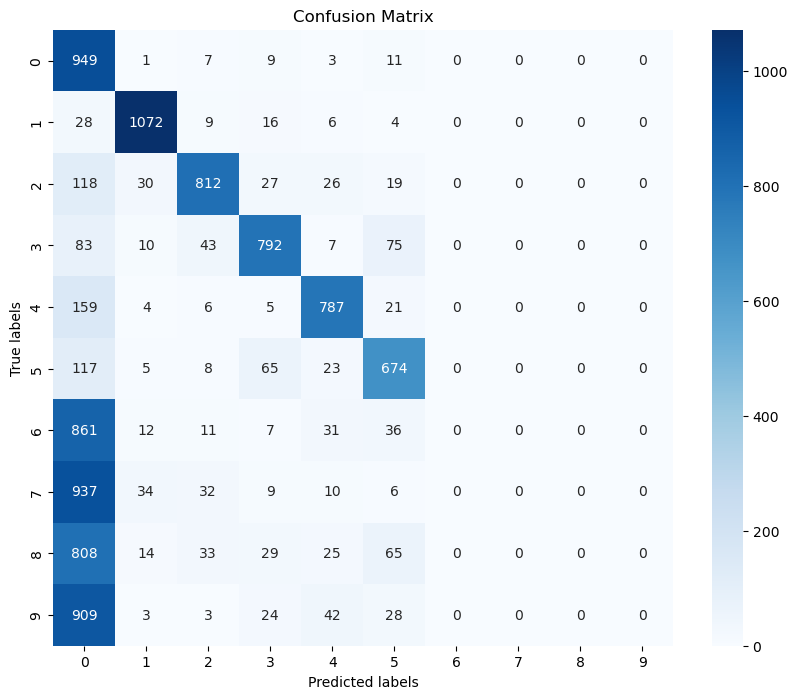

Precision: 0.43422637024637717
Recall: 0.5086
F1 Score: 0.4456568367668422
True Positives for Each Class: [ 949 1072  812  792  787  674    0    0    0    0]
              precision    recall  f1-score   support

           0       0.19      0.97      0.32       980
           1       0.90      0.94      0.92      1135
           2       0.84      0.79      0.81      1032
           3       0.81      0.78      0.79      1010
           4       0.82      0.80      0.81       982
           5       0.72      0.76      0.74       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.51     10000
   macro avg       0.43      0.50      0.44     10000
weighted avg       0.43      0.51      0.45     10000



C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_clas

In [10]:
forget_class = 6
with open('forget_7_mnistdt.py','r') as f:
    tree_ifel_code = f.readlines()
    f.close()
    
for idx,line in enumerate(tree_ifel_code):
    if f'label_class= {forget_class}' in line:
        tree_ifel_code[idx] = ''
        tree_ifel_code[idx-1] = ''
        

with open(f'forget_{forget_class}_mnistdt.py', 'w') as f:
    f.writelines(tree_ifel_code)
    f.close()


from forget_6_mnistdt import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))


import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 0
        
print(accuracy_score(y_test, y_test_pred_tree))

cm = confusion_matrix(y_test, y_test_pred_tree)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)

#### Forgetting class 5

0.4423


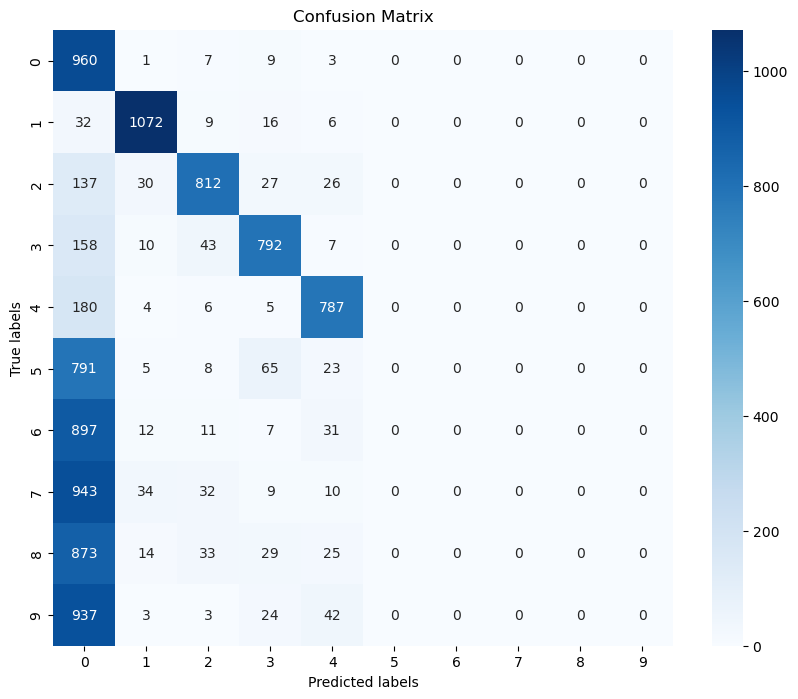

Precision: 0.36740768784685035
Recall: 0.4423
F1 Score: 0.37603757145001643
True Positives for Each Class: [ 960 1072  812  792  787    0    0    0    0    0]
              precision    recall  f1-score   support

           0       0.16      0.98      0.28       980
           1       0.90      0.94      0.92      1135
           2       0.84      0.79      0.81      1032
           3       0.81      0.78      0.79      1010
           4       0.82      0.80      0.81       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.44     10000
   macro avg       0.35      0.43      0.36     10000
weighted avg       0.37      0.44      0.38     10000



C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_clas

In [11]:
forget_class = 5
with open('forget_6_mnistdt.py','r') as f:
    tree_ifel_code = f.readlines()
    f.close()
    
for idx,line in enumerate(tree_ifel_code):
    if f'label_class= {forget_class}' in line:
        tree_ifel_code[idx] = ''
        tree_ifel_code[idx-1] = ''
        

with open(f'forget_{forget_class}_mnistdt.py', 'w') as f:
    f.writelines(tree_ifel_code)
    f.close()


from forget_5_mnistdt import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))


import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 0
        
print(accuracy_score(y_test, y_test_pred_tree))

cm = confusion_matrix(y_test, y_test_pred_tree)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)

#### Forgetting class 4

0.3639


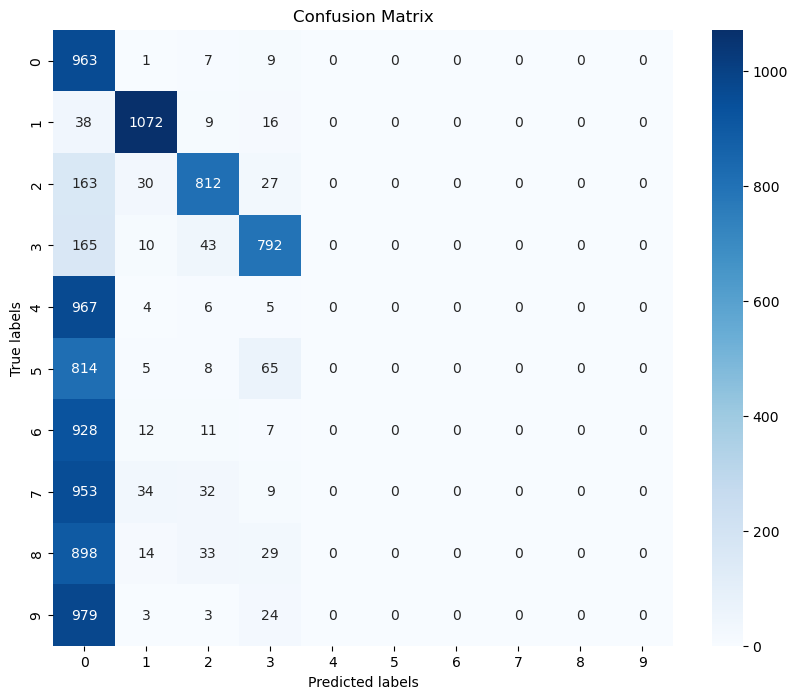

Precision: 0.2847210937935399
Recall: 0.3639
F1 Score: 0.2931794018970438
True Positives for Each Class: [ 963 1072  812  792    0    0    0    0    0    0]
              precision    recall  f1-score   support

           0       0.14      0.98      0.25       980
           1       0.90      0.94      0.92      1135
           2       0.84      0.79      0.81      1032
           3       0.81      0.78      0.79      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.36     10000
   macro avg       0.27      0.35      0.28     10000
weighted avg       0.28      0.36      0.29     10000



C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_clas

In [12]:
forget_class = 4
with open('forget_5_mnistdt.py','r') as f:
    tree_ifel_code = f.readlines()
    f.close()
    
for idx,line in enumerate(tree_ifel_code):
    if f'label_class= {forget_class}' in line:
        tree_ifel_code[idx] = ''
        tree_ifel_code[idx-1] = ''
        

with open(f'forget_{forget_class}_mnistdt.py', 'w') as f:
    f.writelines(tree_ifel_code)
    f.close()


from forget_4_mnistdt import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))


import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 0
        
print(accuracy_score(y_test, y_test_pred_tree))

cm = confusion_matrix(y_test, y_test_pred_tree)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)

#### Forgetting class 3

0.2856


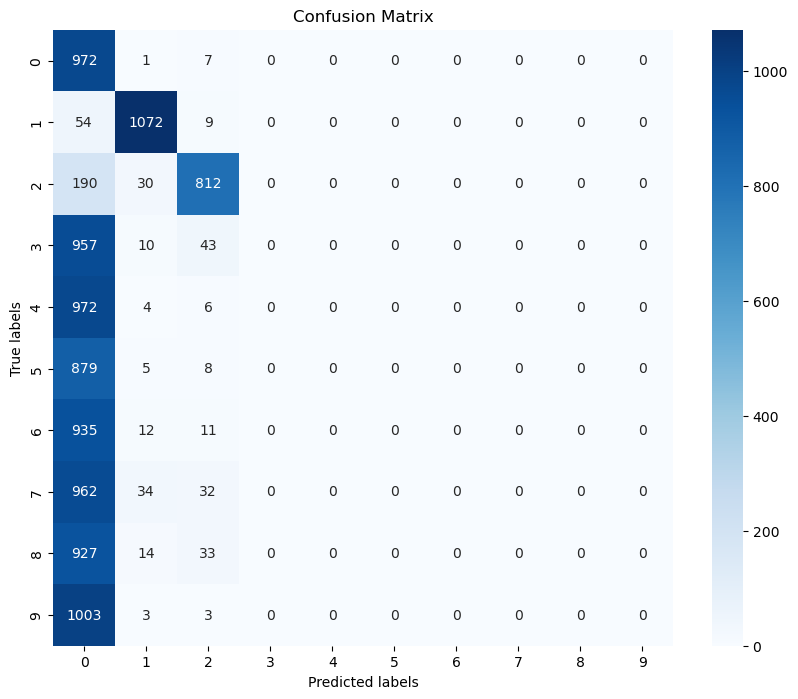

Precision: 0.2017375707696881
Recall: 0.2856
F1 Score: 0.21042908261749757
True Positives for Each Class: [ 972 1072  812    0    0    0    0    0    0    0]
              precision    recall  f1-score   support

           0       0.12      0.99      0.22       980
           1       0.90      0.94      0.92      1135
           2       0.84      0.79      0.81      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.29     10000
   macro avg       0.19      0.27      0.20     10000
weighted avg       0.20      0.29      0.21     10000



C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_clas

In [13]:
forget_class = 3
with open('forget_4_mnistdt.py','r') as f:
    tree_ifel_code = f.readlines()
    f.close()
    
for idx,line in enumerate(tree_ifel_code):
    if f'label_class= {forget_class}' in line:
        tree_ifel_code[idx] = ''
        tree_ifel_code[idx-1] = ''
        

with open(f'forget_{forget_class}_mnistdt.py', 'w') as f:
    f.writelines(tree_ifel_code)
    f.close()


from forget_3_mnistdt import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))


import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 0
        
print(accuracy_score(y_test, y_test_pred_tree))

cm = confusion_matrix(y_test, y_test_pred_tree)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)

#### Forgetting class 2

0.2051


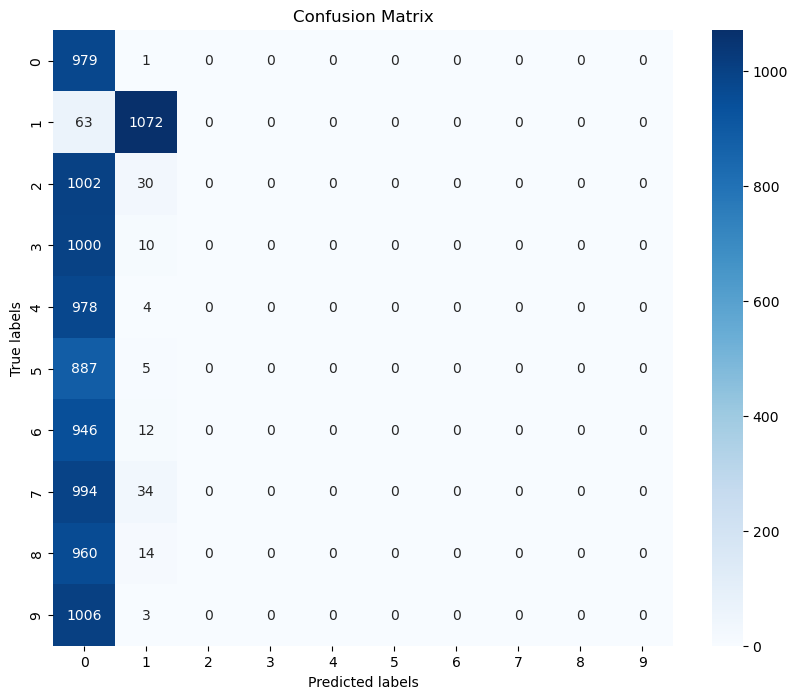

Precision: 0.1135607410651675
Recall: 0.2051
F1 Score: 0.12447965006776855
True Positives for Each Class: [ 979 1072    0    0    0    0    0    0    0    0]
              precision    recall  f1-score   support

           0       0.11      1.00      0.20       980
           1       0.90      0.94      0.92      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.21     10000
   macro avg       0.10      0.19      0.11     10000
weighted avg       0.11      0.21      0.12     10000



C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_clas

In [14]:
forget_class = 2
with open('forget_3_mnistdt.py','r') as f:
    tree_ifel_code = f.readlines()
    f.close()
    
for idx,line in enumerate(tree_ifel_code):
    if f'label_class= {forget_class}' in line:
        tree_ifel_code[idx] = ''
        tree_ifel_code[idx-1] = ''
        

with open(f'forget_{forget_class}_mnistdt.py', 'w') as f:
    f.writelines(tree_ifel_code)
    f.close()


from forget_2_mnistdt import decision_tree_inference
y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))


import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 0
        
print(accuracy_score(y_test, y_test_pred_tree))

cm = confusion_matrix(y_test, y_test_pred_tree)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)

# Now relearning the forgetted label.

#### Learning again the label 2. Use the dataset for class 0 as well along with 2.

In [48]:
relearn_class = 2

# Filter dataset to include only classes 0 and 2
X_02_train = X_train[(y_train == 0) | (y_train == 2)]
y_02_train = y_train[(y_train == 0) | (y_train == 2)]

X_02_test = X_test[(y_test == 0) | (y_test == 2)]
y_02_test = y_test[(y_test == 0) | (y_test == 2)]

# Train a decision tree classifier
clf02_dt = tree.DecisionTreeClassifier(max_depth=8)
clf02_dt.fit(X_02_train, y_02_train)

# Make predictions
y_pred = clf02_dt.predict(X_02_test)

# Evaluate accuracy
accuracy = accuracy_score(y_02_test, y_pred)
print("Accuracy:", accuracy)

class_names = ['0','2']
#Now extract rules
rules = get_rules(clf02_dt, features, class_names)

#Extract rules for class 2
class_2rules = []
for idx,line in enumerate(rules):
    if f'label_class= {relearn_class}' in line:
        class_2rules.append(line)
        
#Create a python file by appending these rules in model that has learned classes 0,1
with open('forget_3_mnistdt.py','r') as f:
    tree_ifel_code = f.readlines()
    f.close()
        
with open(f'relearn_{relearn_class}_mnistdt.py', 'w') as f:
    f.writelines(tree_ifel_code[:-1])
    f.writelines('\n')
    f.writelines('\n'.join(class_2rules))
    f.writelines('\n'+tree_ifel_code[-1])
    f.close()

Accuracy: 0.9821073558648111


0.1982


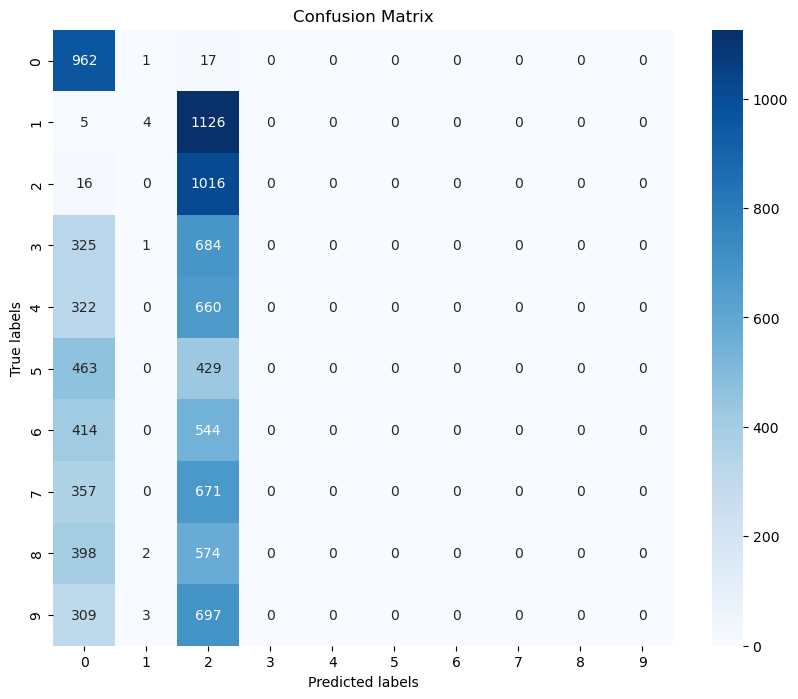

Precision: 0.08401022736762803
Recall: 0.1982
F1 Score: 0.07037118858023393
True Positives for Each Class: [ 962    4 1016    0    0    0    0    0    0    0]
              precision    recall  f1-score   support

           0       0.27      0.98      0.42       980
           1       0.36      0.00      0.01      1135
           2       0.16      0.98      0.27      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.20     10000
   macro avg       0.08      0.20      0.07     10000
weighted avg       0.08      0.20      0.07     10000



C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_clas

In [54]:
import relearn_2_mnistdt 
from relearn_2_mnistdt import decision_tree_inference
import importlib
importlib.reload(relearn_2_mnistdt)
from relearn_2_mnistdt import decision_tree_inference

y_test_pred_tree = []
for i,test_samples in enumerate(X_test):
    y_test_pred_tree.append(decision_tree_inference(test_samples))


import random
for i in range(len(y_test_pred_tree)):
    if y_test_pred_tree[i] is None:
        y_test_pred_tree[i] = 0
        
print(accuracy_score(y_test, y_test_pred_tree))

cm = confusion_matrix(y_test, y_test_pred_tree)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_test_pred_tree, average='weighted')
recall = recall_score(y_test, y_test_pred_tree, average='weighted')
f1 = f1_score(y_test, y_test_pred_tree, average='weighted')
true_positives = np.diag(cm)
# Print the values
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print("True Positives for Each Class:", true_positives)

from sklearn.metrics import classification_report
# Calculate classification report
report = classification_report(y_test, y_test_pred_tree)
# Print the classification report
print(report)

### Hmm, the outcome is, the model forget the learning for class 1 because this calss has not been used while learning class 2. Additional investigation is needed.

#### Ideally the solution are as follows:
1. Generate a sklearn model from the extracted rules. 
2. Now use that model to progressively learn class 2 without forgetting the already learned classes (0,1).

Such a mechanism is available in the neural network model but not known about the decision tree. Further, there is no mechansim to build sklearn model from the extracted rules.